In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization, TextVectorization
from keras.metrics import Recall
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import backend as K

In [2]:
print('Tensorflow version:', tf.__version__)
print(tf.config.list_physical_devices('GPU'))
!python --version

Tensorflow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Python 3.9.19


## 1. Problem Description and Dataset
Context and nuance play a significant role in understanding language, especially in situations like announcing disasters. While humans can often discern metaphorical usage from literal language, machines might struggle without additional context cues.

For example: 'Our project deadlines are going up in flames, but we're ready to extinguish the fire with our teamwork!'. The phrase: 'going up in flames' creates a vivid image of a fire, symbolizing the urgency and severity of the situation. However, the meaning is metaphorical.

A machine learning model will thus need to consider the sequential nature of a text (such as a tweet), including the numerical representation and significance of each word, along with the influence and contribution of other words within the same sequence.

The dataset for this project comes from Kaggle, which originally was created by the company Figure-Eight. The task is to predict whether a given tweet is about a real disaster or not(text classification). Submissions are evaluated using F1 between the predicted and expected answers. F1 is calculated as follows:
$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$
where:
$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

NLP poses a challenging problem for computers to solve, yet recent advancements have significantly improved a wide range of NLP tasks, including language modeling, machine translation, text classification and sentiment analysis.

More about our dataset: each train and test set contains the following information:
* id: a unique identifier for each tweet
* text: the text of the tweet
* location: the location the tweet was sent from
* keyword: a particular keyword from the tweet.
* target: denotes whether a tweet is about a real disaster (1) or not (0)

## 2. Exploratory Data Analysis

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Training data shape:', train.shape)
print('Test data shape:', test.shape)

Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [4]:
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


There are null values in both keyword and location. We will replace NaNs with 'None' in keyword since we will use keyword as one of the feature in our model.

In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# Replace NaNs with 'None'
train['keyword'] = train['keyword'].fillna('None')
test['keyword'] = test['keyword'].fillna('None')

train['location'] = train['location'].fillna('None')
test['location'] = test['location'].fillna('None')

### Duplicated Tweets and Mislabeled Target
There are `7613 unique id` in train data, however, there are only `7503 unique text`. We can conclude that there are duplications in tweets. Some duplicated text comes from different ids, this is likely due to re-tweets. It's better to remove duplicates to avoid overfitting the patterns that are present in those duplicates.

There are 18 tweets that are labeled differently in their duplicates. Same tweets, different target label. To address this issue, I created a new column: 'target_relabeled', then used majority voting in deciding the 'correct' target label. If there is no majority, it is decided by context case by case.

In [7]:
train.nunique()

id          7613
keyword      222
location    3341
text        7503
target         2
dtype: int64

In [8]:
text_multiple = train.groupby('text')['text'].transform('count')

In [21]:
pd.set_option('display.max_colwidth', None)

In [14]:
train[text_multiple >= 7].head(4)

,id,keyword,location,text,target
3578,5113,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3589,5127,fatal,Varanasi,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3591,5130,fatal,Thane,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
3597,5137,fatal,NaN,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1


In [16]:
mislabeled = train.groupby('text').nunique().sort_values(by='target', ascending=False)
mislabeled = mislabeled[mislabeled['target'] > 1]['target']

mislabeled_idx = []
for i, txt in enumerate(train['text']):
    if txt in mislabeled:
        mislabeled_idx.append(i)   

In [17]:
train['target_relabeled'] = train['target'].copy()

train.loc[[610, 630], 'target_relabeled'] = 0
train.loc[[1197], 'target_relabeled'] = 0
train.loc[[1365], 'target_relabeled'] = 0
train.loc[[1221], 'target_relabeled'] = 0
train.loc[[2832], 'target_relabeled'] = 1
train.loc[[3243, 3248], 'target_relabeled'] = 0
train.loc[[4013, 4019], 'target_relabeled'] = 1
train.loc[[4235], 'target_relabeled'] = 1
train.loc[[4239], 'target_relabeled'] = 0
train.loc[[4292, 4318], 'target_relabeled'] = 0
train.loc[[4305], 'target_relabeled'] = 0
train.loc[[4312], 'target_relabeled'] = 0
train.loc[[4320], 'target_relabeled'] = 0
train.loc[[4379], 'target_relabeled'] = 1
train.loc[[4618], 'target_relabeled'] = 1
train.loc[[5620], 'target_relabeled'] = 0
train.loc[[6091, 6123], 'target_relabeled'] = 0
train.loc[[6616], 'target_relabeled'] = 0

Check the result after relabeled:

In [24]:
train.iloc[mislabeled_idx][['id', 'text', 'target', 'target_relabeled']].head(4)

,id,text,target,target_relabeled
610,881,To fight bioterrorism sir.,1,0
624,898,To fight bioterrorism sir.,0,0
630,907,To fight bioterrorism sir.,1,0
634,916,To fight bioterrorism sir.,0,0


We can now drop duplicated tweets after addressing mislabeled class problem.

In [5]:
# Drop duplicates
train = train.drop_duplicates(subset=['text'], ignore_index=True)
print('Training data shape after we drop duplicates:', train.shape)

Training data shape after we drop duplicates: (7503, 6)


### Target Label Distribution
As can be seen from the histogram plot of our target label below, the dataset is slightly imbalanced. We can use sklearn's class_weight to estimate class weights for unbalanced dataset, and see if this would help the model learn better from the imbalanced data.

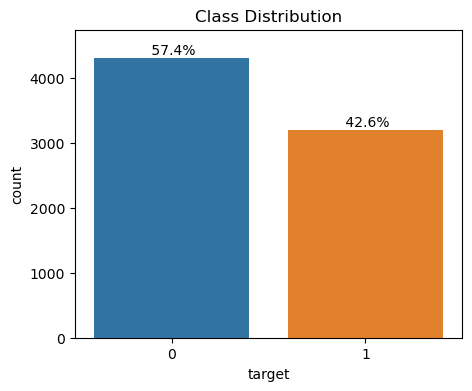

In [58]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=train, x='target', width=0.8)
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/len(train))*100: 0.1f}%')
ax.margins(y=0.1)
ax.set_title('Class Distribution');

### Keyword and Location
We plotted keyword count distribution for each target label below. They have different distributions, that may be valuable for our classification task. Both 'Keyword' and 'Location' can be added to the tweets.

In [19]:
# example of keyword that contains '%20', which is an encoding for space.
train.iloc[[1222, 1223]]

,id,keyword,location,text,target,target_relabeled,num_char,num_word,num_sentence,cleaned_text,polarity,subjectivity
1222,1771,buildings on fire,World Wide,Fire hazard associated with installation of no...,1,1,122,17,1,fire hazard associate installation noncomplian...,0.0,0.10
1223,1772,buildings on fire,Intermountain West,.@greenbuildermag @NFPA to hold free webinar o...,1,1,131,25,3,green builder mag nfpa hold free webinar wildf...,0.1,0.55


In [19]:
def keyword_correction(txt):
    txt = re.sub(r'%20', ' ', txt)
    return txt

In [7]:
keyword_correction('buildings%20on%20fire')

'buildings on fire'

In [8]:
train['keyword'] = [keyword_correction(w) for w in train.keyword]
test['keyword'] = [keyword_correction(w) for w in test.keyword]

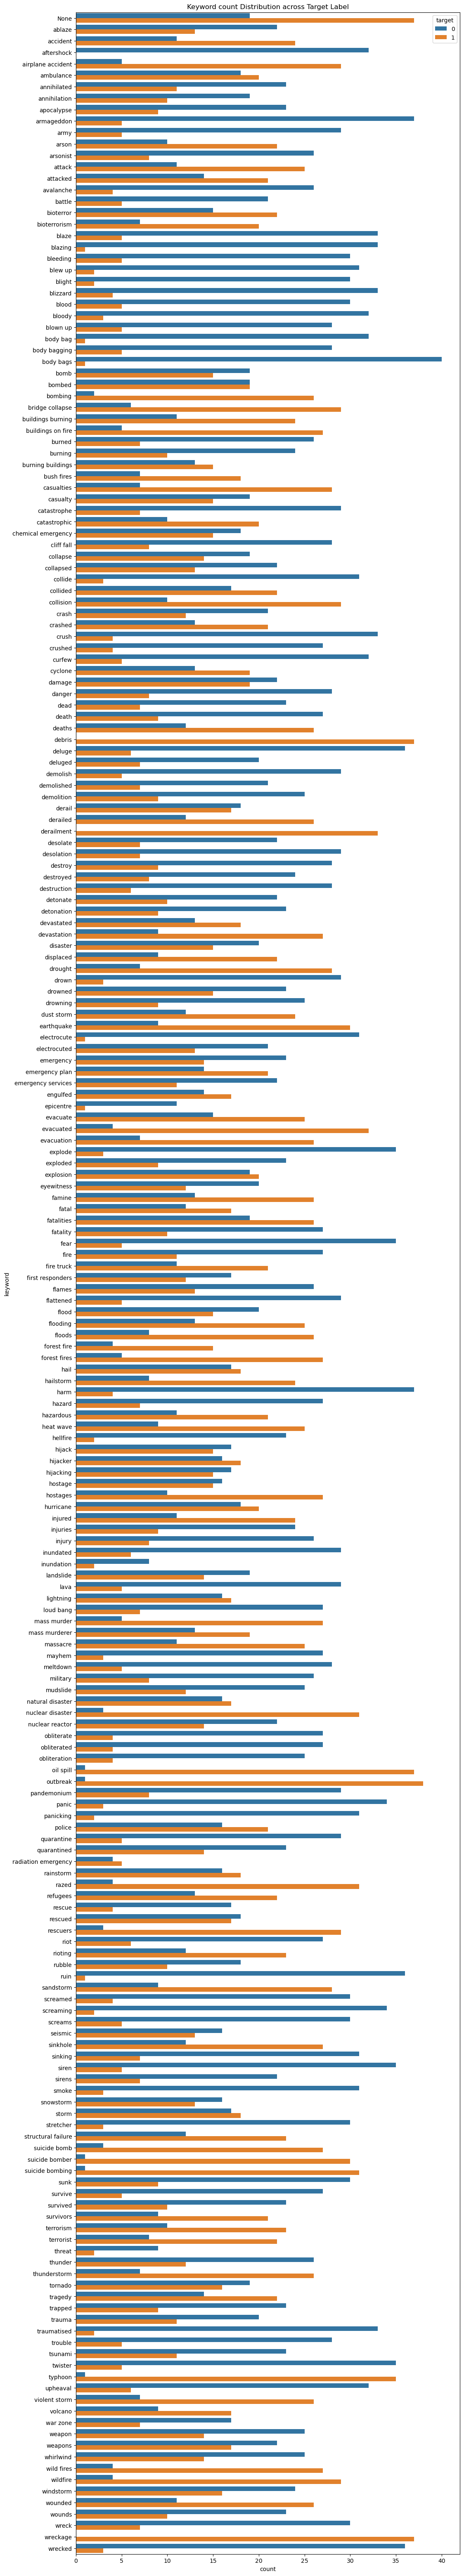

In [17]:
plt.figure(figsize=(12, 80))
sns.countplot(data=train, y='keyword', hue='target')
plt.title('Keyword count Distribution across Target Label');

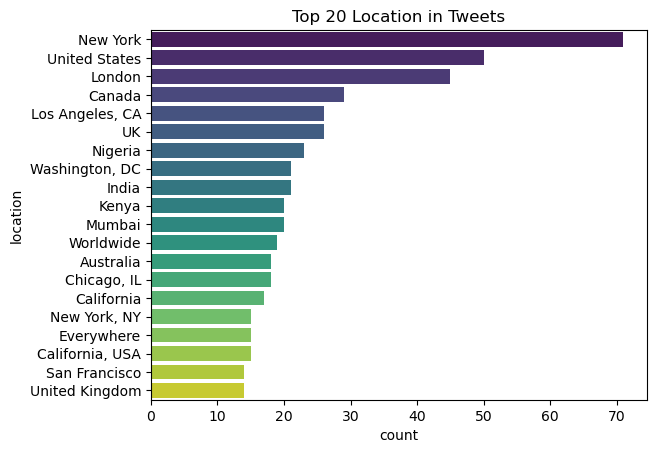

In [18]:
locations = train['location'].value_counts()
sns.barplot(x=locations[1:21], y=locations[1:21].index, palette='viridis')
plt.title('Top 20 Location in Tweets');

### Character Count - Word Count - Sentence Count
The distribution of character-count, word-count, and sentence-count are quite different for disaster and non-disaster tweets. The reason maybe that tweets about actual disasters might originate from news agencies, characterized by a more formal tone and the use of longer vocabulary compared to tweets not related to disasters. These features could be valuable, hence we will incorporate them in our feature-based model.

In [9]:
# count the number of characters in each tweet
train['num_char'] = train.text.str.len()
test['num_char'] = test.text.str.len()

# count the number of words in each tweet
train['num_word'] = [len(word_tokenize(txt)) for txt in train.text]
test['num_word'] = [len(word_tokenize(txt)) for txt in test.text]

# count the number of sentence in each tweet
train['num_sentence'] = [len(sent_tokenize(txt)) for txt in train.text]
test['num_sentence'] = [len(sent_tokenize(txt)) for txt in test.text]

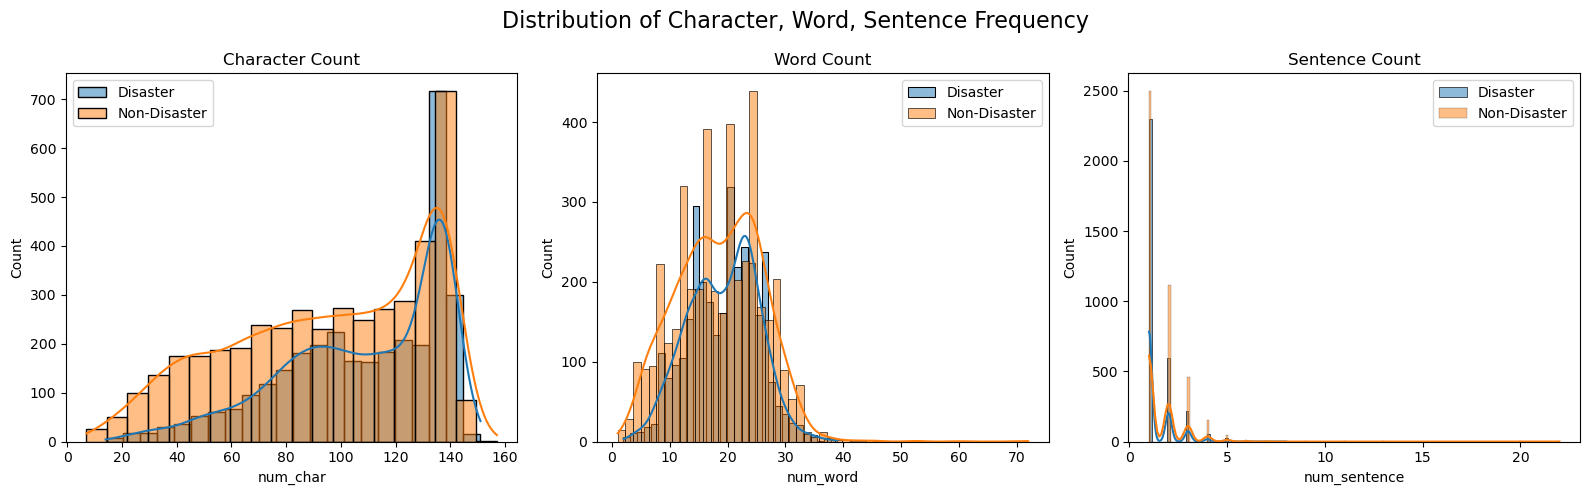

In [50]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

cols = train.columns[-3:].tolist()
titles = ['Character Count', 'Word Count', 'Sentence Count']

plt.figure(figsize=(16, 5))
plt.suptitle('Distribution of Character, Word, Sentence Frequency', fontsize=16)
for i, col in enumerate(np.arange(3)):
    plt.subplot(1, 3, i+1)
    sns.histplot (train[train.target == 1][cols[i]], label='Disaster', kde=True).set_title(titles[i])
    sns.histplot (train[train.target == 0][cols[i]], label='Non-Disaster', kde=True).set_title(titles[i])
    plt.legend()
plt.tight_layout()

### Cleaning Functions

### Remove non-ASCII characters
I noticed in the tweet (text), there are many non-ASCII characters. I will print out some example cases below. We will define a function to remove these non-ASCII characters.

In [30]:
# example text that contains non-ASCII characters
train.text[[157, 185, 195]]

157    Horrible Accident Man Died In Wings Of ÛÏAirplaneÛ 29-07-2015. WTF You CanÛªt Believe Your EYES ÛÒ... http://t.co/6fFyLAjWpS
185                        EMS1: NY EMTs petition for $17 per hour Û÷minimum wageÛª http://t.co/4oa6SWlxmR #ems #paramedics #ambulance
195                               ÛÏ@LeoBlakeCarter: This dog thinks he's an ambulance ?????? http://t.co/MG1lpGr0RMÛ@natasha_rideout
Name: text, dtype: object

In [10]:
def remove_non_ASCII(txt):
    txt = ''.join([word for word in txt if word in string.printable])
    return txt

In [31]:
# test the function
print(remove_not_ASCII(train.text[157]))
print(remove_not_ASCII(train.text[185]))
print(remove_not_ASCII(train.text[195]))

Horrible Accident Man Died In Wings Of Airplane 29-07-2015. WTF You Cant Believe Your EYES ... http://t.co/6fFyLAjWpS
EMS1: NY EMTs petition for $17 per hour minimum wage http://t.co/4oa6SWlxmR #ems #paramedics #ambulance
@LeoBlakeCarter: This dog thinks he's an ambulance ?????? http://t.co/MG1lpGr0RM@natasha_rideout


### Remove Emoji

In [11]:
# Ref: https://stackoverflow.com/a/69568363
# we put this pattern outside of the function remove_emoji, so it won't have to re-compiled each time the function is called
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"   # emoticons
                        u"\U0001F300-\U0001F5FF"   # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"   # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"   # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"                  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"   # Chinese char
                        u"\U00010000-\U0010ffff"
                        "]+", flags=re.UNICODE)

In [12]:
def remove_emoji(txt):
    return emoji_pattern.sub(r' ', txt)

In [13]:
example_txt = 'support.google.co.uk/s/.💻, 😭😱😷'
remove_emoji(example_txt)

'support.google.co.uk/s/. ,  '

### Remove URLs
Many texts contain URLs. In some cases, instead of removing URL, we can use regex to retrieve the domain name; or even use nlp based methods that study the link content. However, upon more observations, the URLs in our text data is the shortened URL that Twitter uses (http://t.co link.). We won't spend more time in finding out the domain of these shortened URL, we'll just remove them for now.

In [13]:
def remove_url(txt):
    return ' '.join(re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', txt).split())

In [42]:
# example text that contains URLs
train.text[197]

'http://t.co/FueRk0gWui Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/Mv7GgGlmVc'

In [44]:
# test the function
remove_url(train.text[197])

'Twelve feared killed in Pakistani air ambulance helicopter crash'

### Replace Character Entity References
Some text contains character entity references such as:
* '&amp;gt;'  (greater than sign)
* '&amp;lt;'  (less than sign)
* '&amp;amp;' (ampersand)

We will replace them with their corresponding character. We will implement this in our clean(text) function. Character entity references: [Wikipedia Link](https://en.wikipedia.org/wiki/List_of_XML_and_HTML_character_entity_references)

### Remove user handle in 'mention'
Removing mentions (like @username) from tweets is appropriate for this task. We want to focus on the content of the tweet itself, we are not trying to understand interactions between users.

In [14]:
def remove_mention(txt):
    at = re.compile(r'@\S+')
    return at.sub(r'', txt)

In [47]:
train.text[147]

"@mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best."

In [48]:
remove_mention(train.text[147])

"  That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best."

### Hashtag - Word Segmentation
Hashtags often condense the main idea of a tweet into a single word or phrase. This semantic information can be useful for understanding the tweet's content and classifying it correctly. Hashtagged words often contains name entity. For example: '#CityofCalgary', '#CAfire'. We want to preprocess them into: 'city of calgary', 'ca fire'. Wordsegment can do this for us.

Wordsegment is developed by Grant Jenks ([Link here](https://pypi.org/project/wordsegment/)). It is a Python library specifically designed for English word segmentation. It is used to split compound words or phrases into their constituent parts or tokens. This can be particularly useful in natural language processing tasks where breaking down compound words can aid in understanding or processing text.

In [24]:
pip install wordsegment

  Using cached wordsegment-1.3.1-py2.py3-none-any.whl.metadata (7.7 kB)
Using cached wordsegment-1.3.1-py2.py3-none-any.whl (4.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
from wordsegment import load, segment
load()

In [16]:
def word_segmentation(txt):
    segmented_txt = segment(txt)
    return ' '.join(segmented_txt)

In [18]:
# example use of wordsegment
print('Original text          :', test.text[3262])
print('After word segmentation:', word_segmentation(test.text[3262]))

Original text          : #CityofCalgary has activated its Municipal Emergency Plan. #yycstorm
After word segmentation: city of calgary has activated its municipal emergency plan yyc storm


In [19]:
# another example
print('Original text          :', train.text[5])
print('After word segmentation:', word_segmentation(train.text[5]))

Original text          : #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
After word segmentation: rocky fire update california hwy20 closed in both directions due to lake county fire ca fire wildfires


### Contractions
Expanding contractions in NLP involves converting contracted forms of words into their full forms. For example, "don't" becomes "do not," "can't" becomes "cannot," and so forth. This process is important because it helps standardize text and ensures consistency in our text classification task. We will use python library contractions by PascalVKooten ([Link here](https://pypi.org/project/contractions/)).

In [21]:
!pip install contractions

  Using cached contractions-0.1.73-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached anyascii-0.3.2-py3-none-any.whl.metadata (1.5 kB)
Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
Using cached anyascii-0.3.2-py3-none-any.whl (289 kB)


In [17]:
import contractions

In [19]:
def expand_contractions(txt):
    expanded_words = []
    for w in txt.split():
        expanded_words.append(contractions.fix(w))
    return ' '.join(expanded_words)

In [20]:
# example usage of contractions library
example_txt = "don't, can't, cant, you're, i'm, ima, gotta, wanna, won't, ain't"
print('Original text               :', example_txt)
print('After expanding contractions:', expand_contractions(example_txt))

Original text               : don't, can't, cant, you're, i'm, ima, gotta, wanna, won't, ain't
After expanding contractions: do not, cannot, cannot, you are, i am, i am about to, got to, want to, will not, are not


### Prune Repeating Identical Characters

In [66]:
train.text[19]

'What a goooooooaaaaaal!!!!!!'

In [67]:
re.sub(r'(\w)\1{2,}', r'\1', train.text[19])

'What a goal!!!!!!'

We will implement this regex in the clean_tweet function

### Lemmatization
Lemmatization is a text pre-processing technique used in natural language processing (NLP) models to break a word down to its root meaning to identify similarities. For example, a lemmatization algorithm would reduce the word `better` to its root word, or lemme, `good`.

We use WordNetLemmatizer module from nltk, and will implement lemmatization in our clean_tweet function.

In [21]:
lemmatizer = WordNetLemmatizer()

### Clean Tweets
Define clean_tweet functions that perform cleaning on input tweet (text). Punctuations and stopwords will be removed. We use string.punctuation and stopwords from nltk.corpus

In [17]:
# use string.punctuation to remove punctuation
print('Punctuations that will be removed:', string.punctuation)

Punctuations that will be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [10]:
# get the stopwords from nltk.corpus
stop_words = stopwords.words('english')

In [19]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
def remove_stopwords_tolower(txt):
    word_token = word_tokenize(txt)
    return ' '.join([w.lower() for w in word_token if not w.lower() in stop_words])

In [39]:
def clean_tweet(txt):
    txt = remove_url(txt)   
    txt = remove_mention(txt)
    txt = remove_emoji(txt)
    txt = expand_contractions(txt)

    # remove punctuations
    txt = ''.join([char for char in txt if char not in string.punctuation])

    txt = remove_stopwords_tolower(txt)
    
    # remove character entity references
    txt = re.sub(r'amp', ' ', txt)

    # remove numbers or numbers followed by letters such as 20K
    txt = re.sub('[0-9]\w*', ' ', txt)

    # prune repeating identical characters
    txt = re.sub(r'(\w)\1{2,}', r'\1', txt)
    
    txt = remove_non_ASCII(txt)
    
    txt = word_segmentation(txt)

    # tokenize
    words = word_tokenize(txt)

    # make sure all the characters are alphabet letters
    words = [w for w in words if w.isalpha()]

    # lemmatize
    cleaned_txt = ' '.join([lemmatizer.lemmatize(w.lower(), pos='v') for w in words])

    return cleaned_txt

In [41]:
print('Original text              :', train.text[150])
print('After clean_tweet() applied:', clean_tweet(train.text[150]))

Original text              : Horrible Accident |  Man Died In Wings of AirplaneåÊ(29-07-2015) http://t.co/wq3wJsgPHL
After clean_tweet() applied: horrible accident man die wing airplane


In [44]:
import time
start_time = time.time()
train['cleaned_text'] = train['text'].apply(lambda txt: clean_tweet(txt))
test['cleaned_text'] = test['text'].apply(lambda txt: clean_tweet(txt))
end_time = time.time()
elapsed_time = end_time - start_time
print("Text Preprocessing in training and test data completed in: {:.2f} minutes.".format(elapsed_time/60))

Text Preprocessing in training and test data completed in: 9.96 minutes.


In [53]:
# compare original text and the cleaned text
train[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,residents ask shelter place notify officer evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",people receive wildfires evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,get send photo ruby alaska smoke wildfires pour school


### Wordcloud of Most Common Words across Target Label

In [3]:
from wordcloud import WordCloud

In [5]:
corpus0 = [w for txt in train[train.target == 0].cleaned_text for w in word_tokenize(txt)]

corpus1 = [w for txt in train[train.target == 1].cleaned_text for w in word_tokenize(txt)]

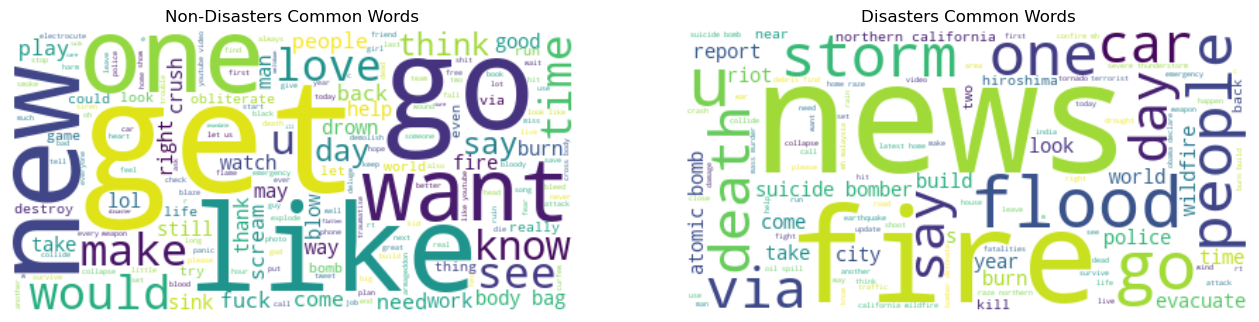

In [11]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
wc = WordCloud(stopwords=stop_words, background_color='white').generate(' '.join(corpus0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Non-Disasters Common Words')
plt.axis('off')
plt.subplot(1, 2, 2)
wc = WordCloud(background_color='white').generate(' '.join(corpus1))
plt.imshow(wc, interpolation='bilinear')
plt.title('Disasters Common Words')
plt.axis('off')
plt.show()

### Meta Feature
We'll use textblob library module TextBlob.sentiment to extract features from the tweets. These extracted features (polarity and subjectivity) may help discern between real disasters or non-disasters tweets.
* polarity: it ranges from -1 to 1, where -1 defines a negative sentiment and 1 defines a positive sentiment
* subjectivity: this ranges from 0 to 1, where 0 is very objective and 1 is very subjective

In [50]:
pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ----------- ---------------------------- 174.1/626.3 kB 3.5 MB/s eta 0:00:01
   -------------------------------- ------- 512.0/626.3 kB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [70]:
from textblob import TextBlob

In [83]:
train['polarity'] = [TextBlob(txt).sentiment.polarity for txt in train.cleaned_text]
train['subjectivity'] = [TextBlob(txt).sentiment.subjectivity for txt in train.cleaned_text]

# perform the same operations on the test data
test['polarity'] = [TextBlob(txt).sentiment.polarity for txt in test.cleaned_text]
test['subjectivity'] = [TextBlob(txt).sentiment.subjectivity for txt in test.cleaned_text]

### Save Preprocessed Data

In [86]:
train.to_pickle('train_preprocessed.pkl')
test.to_pickle('test_preprocessed.pkl')

### Get Preprocessed data

In [2]:
train = pd.read_pickle('train_preprocessed.pkl')
test = pd.read_pickle('test_preprocessed.pkl') 

## 3. Model Architecture
For this text classification task, I will utilize models from the Recurrent Neural Network (RNN) family. This choice is informed by the inherent sequential nature of tweets; each word depends on the preceding ones to convey meaning, and understanding the context of a tweet necessitates considering the order of the words within the sequence.

RNNs are designed to efficiently process sequential data by introducing connections between units within the network that form directed cycles. This cyclic structure allows RNNs to maintain information across time steps, making them well-suited for tasks involving sequential data. RNNs have feedback connections that enable them to capture temporal dependencies in data. Long Short-Term Memory (LSTM) networks is a variant of RNNs that address some of the limitations of traditional RNNs, such as the vanishing gradient problem. 

Below is a Many-to-one RNN type for our task. It will first read the input, a tweet, then determine whether it is a tweet about real disaster or not:

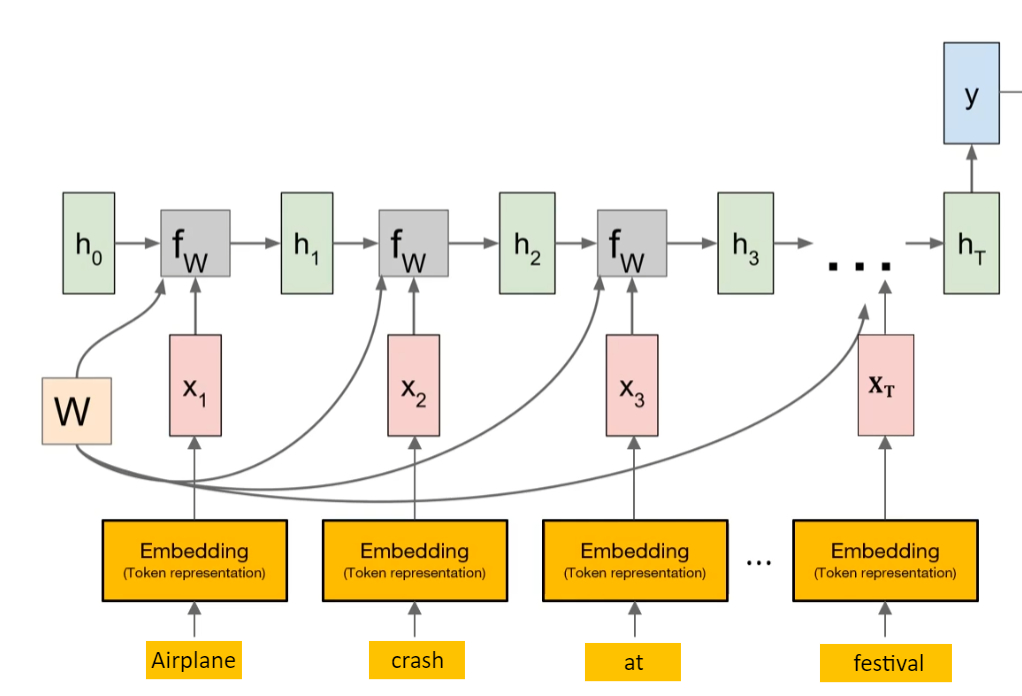

Original Image credit: [Link](https://goodboychan.github.io/python/deep_learning/tensorflow-keras/2020/12/06/01-RNN-Many-to-one.html)

In order to do this we first need to represent the word in a format that can be understood by the neural network. Word embeddings provide a solution by representing words as numerical vectors in a high-dimensional space. Each word is mapped to a point in this space, where its position encodes semantic relationships with other words. Words with similar meanings are closer to each other in the vector space. These vectors are learned from data, typically using techniques like Word2Vec, GloVe (Global Vectors for Word Representation), or more recently, transformer-based models like BERT (Bidirectional Encoder Representations from Transformers), RoBERTa (Robustly optimized BERT approach) or GPT (Generative Pre-trained Transformer).

The figure below shows featurized representation of words (word embedding), taken from Sequence Models Course by Andrew Ng:

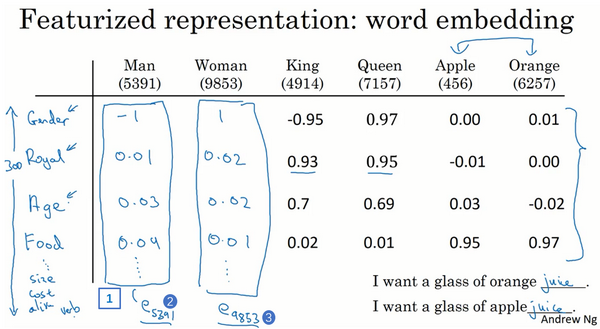

Word embeddings enable algorithms to understand similarities between words by capturing semantic and syntactic relationships. Here are some examples of similar words based on word embeddings:
* Synonyms: 'big' and 'large', 'happy' and 'joyful'
* Antonyms: 'hot' and 'cold', 'happy' and 'sad'
* Hyponyms and Hypernyms: 'cat' (hyponym) and 'animal' (hypernym), 'rose' (hyponym) and 'flower' (hypernym)
* Meronyms and Holonyms: 'wheel' (meronym) and 'car' (holonym), 'petal' (meronym) and 'flower' (holonym)
* Word Analogies: 'king' is to 'queen' as 'man' is to 'woman'
* Contextual Similarity: "cat" and "dog" often appear in similar contexts related to pets

This enables algorithms to generalize and understand linguistic nuances even when encountering unseen words or contexts.


Here are the various models slated for implementation in this project:
* The first model is stacked LSTM with 128-128 or 256-128 units followed by a dense layer with sigmoid activation function.
* Our second model is Bi-directional LSTM with attention. We will perform hyperparameters tuning on the number of units and apply different strengths of regularization.
* The third model utilizes Universal Sentence Encoder, a pre-trained model developed by Google Research. We will tune the number of units in the fully connected (FC) layers, and apply different levels of regularization.
* The fourth model is RoBERTa, a pre-trained model developed by Facebook AI, and it builds upon BERT by addressing some of its limitations and incorporating additional training techniques. We will try 2 different configuration of RoBERTa model: RoBERTa-base and RoBERTa-large. RoBERTa-base is the smaller version. It has fewer parameters and typically is faster to train compared to RoBERTa-large which has with more parameters and greater depth.
* The fifth model will also utilize RoBERTa, but it will be trained on tweets that incorporate 'keyword' and 'location' information.
* Our last model is RandomForestClassifier fitted to our meta-features data (polarity, subjectivity, number of words, number of characters and number of sentences).

## 4. Result and Analysis
### 4.1. Tokenizing and Padding
We will start by tokenizing our cleaned text, then adding pads to the token sequence so they have the same fixed length.

We will create our vocabulary by fitting tokenizer on X_full (all tweets from training and test).

In [3]:
max_len_train = max(train['cleaned_text'].apply(lambda x: len(x.split())).values)
max_len_test = max(test['cleaned_text'].apply(lambda x: len(x.split())).values)
print('Maximum number of words in a tweet for training data:', max_len_train)
print('Maximum number of words in a tweet for test data:', max_len_test)

Maximum number of words in a tweet for training data: 23
Maximum number of words in a tweet for test data: 22


In [4]:
# We set max_len to 24, based on the maximum number of words in training and tweets.
max_len = 24

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_text'].values, 
                                                  train['target_relabeled'].values, 
                                                  shuffle=True, 
                                                  test_size=0.1)

In [19]:
# y_train = np.asarray(y_train).astype('int64').reshape((-1, 1))
# y_val = np.asarray(y_val).astype('int64').reshape((-1, 1))

`tokenizer.fit_on_texts` method: Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency.

`tokenizer.texts_to_sequences` method: Transforms each text to a sequence of integers.

`num_words` argument: allows for controlling the vocabulary size by specifying the maximum number of words to be considered based on their frequency in the dataset.

In [21]:
# Ref: https://stackoverflow.com/questions/64158898/what-does-keras-tokenizer-num-words-specify
sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 2)
tokenizer.fit_on_texts(sentences)
tokenizer.texts_to_sequences(sentences)

[[1], [1], [1]]

In [22]:
tokenizer = Tokenizer(num_words = 10)
tokenizer.fit_on_texts(sentences)
tokenizer.texts_to_sequences(sentences)

[[3, 1, 2, 4], [3, 1, 2, 5], [6, 1, 2, 4]]

In [6]:
X_full = pd.concat([train['cleaned_text'], test['cleaned_text']])

tokenizer = Tokenizer(num_words=20000, oov_token='<UNK>')

# create the vocabulary by fitting on X_full (all tweets from training and test)
tokenizer.fit_on_texts(X_full.values.tolist())

In [7]:
word_index = tokenizer.word_index
print('Found %d unique words.' % len(word_index))

Found 16005 unique words.


In [8]:
# generate the sequence of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [9]:
# pad the sequences
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=max_len)

In [10]:
print('Text example:', X_train[0])
print('\nSequence of indices before padding:', X_train_seq[0])
print('\nSequence of indices after padding:', X_train_pad[0])

Text example: rock bottom rad fm kid remember hear rule days wo defense strip brock obliterate

Sequence of indices before padding: [585, 1676, 3668, 1366, 237, 298, 108, 554, 297, 2594, 1871, 5069, 5331, 145]

Sequence of indices after padding: [ 585 1676 3668 1366  237  298  108  554  297 2594 1871 5069 5331  145
    0    0    0    0    0    0    0    0    0    0]


### 4.2. GloVe (Global Vectors for Word Representation) Embedding
We will use a pretrained embedding from GloVe model (pre-trained on 2B tweets, 27B tokens, 1.2M vocab, 200 dimensional vectors) and create a word-level embedding matrix.

[Glove model link](https://nlp.stanford.edu/projects/glove/)

In [144]:
# load the pickle file
with open('glove.twitter.27B.200d.pkl', 'rb') as f:
    embeddings = pickle.load(f)

# create embedding dictionary
embedding_dict = {}
for word, vector in embeddings.items():
    embedding_dict[word] = np.asarray(vector, dtype='float32')

In [145]:
print('Loaded %s word vectors.' % len(embedding_dict))

Loaded 1193514 word vectors.


Next, we will create an embedding matrix for our vocabulary where each row corresponds to the the tweets in our data. It will have 200 columns, containing our GloVe 200 dimensional vector features; and 16006 rows, corresponding to the length of our dataset's vocabulary size + 1. We added 1 to the number of vocabulary size since index 0 is reserved for `<UNK>` which represents an unknown word or token. It is used to indicate words that were not present in the vocabulary during the training of the word embedding model.

In [146]:
vocab_size = len(word_index)

# initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, 200))

oo_vocab_count = 0
oo_vocab_words = []

for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oo_vocab_words.append(word)
        oo_vocab_count += 1

In [147]:
print('Some out of vocabulary words:', oo_vocab_words[:5])
print('Ouf of vocabulary count:', oo_vocab_count)

Some out of vocabulary words: ['<UNK>', 'bioterrorism', 'bioterror', 'wildhorse', 'crematoria']
Ouf of vocabulary count: 938


There are 938 out of vocabulary words. Let's try another GloVe model (pretrained on 840B tokens, 2.2M vocab, cased, 300 dimensional vectors), and see if we can get less number of out of vocabulary words.

In [10]:
embedding_dict = {}
with open('glove.840B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_dict[word] = weights

In [11]:
print('Size of vocabulary in GloVe:', len(embedding_dict))

Size of vocabulary in GloVe: 2196016


As before, we create an embedding matrix for our vocabulary where each row corresponds to the the tweets in our data.

In [12]:
# initialize embedding matrix with zeros
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))

oo_vocab_count = 0
oo_vocab_words = []

for word, idx in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        oo_vocab_words.append(word)
        oo_vocab_count += 1

In [13]:
# now that we got the embedding_matrix for our tweets, we'll delete embedding_dict to free up some memory
del embedding_dict

In [98]:
print('Some out of vocabulary words:', oo_vocab_words[:10])
print('Ouf of vocabulary count:', oo_vocab_count, 'out of total', vocab_size, '({:.2%})'.format(oo_vocab_count/vocab_size))

Some out of vocabulary words: ['<UNK>', 'bayelsa', 'mediterra', 'gtgtgt', 'mansehra', 'kisii', 'schlichter', 'rohingya', 'fergusons', 'kerrick']
Ouf of vocabulary count: 723 out of total 16006 (4.52%)


With this GloVe model, we encounter fewer out-of-vocabulary words.

### 4.3. Utils Functions

In [15]:
def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def get_callbacks():
    path_checkpoint ='checkpoint_keras.h5'  
    log_dir='logs'   
    callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                         monitor='val_f1_score',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max')
    
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=2, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=1, verbose=1)
    
    callback_early_stopping = EarlyStopping(monitor='val_f1_score',
                                           patience=10,
                                           verbose=1)
    
    callbacks = [reduce_lr, callback_checkpoint, callback_early_stopping]
    return callbacks

def plot_performance(history):
    n = len(history.history['loss'])
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.plot(range(n),history.history['loss'],'-o', label='train loss', markersize=4)
    plt.plot(range(n),history.history['val_loss'],'-o', label='val loss', markersize=4)
    plt.ylabel('Loss', size=12); plt.xlabel('Epoch', size=12)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')

    plt.subplot(1, 3, 2)
    plt.plot(range(n), history.history['accuracy'],'-o', label='train accuracy', markersize=4)
    plt.plot(range(n),history.history['val_accuracy'],'-o', label='val accuracy', markersize=4)
    plt.ylabel('Accuracy', size=12); plt.xlabel('Epoch', size=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    plt.subplot(1, 3, 3)
    plt.plot(range(n), history.history['f1_score'],'-o', label='train F1 score', markersize=4)
    plt.plot(range(n),history.history['val_f1_score'],'-o', label='val F1 score', markersize=4)
    plt.ylabel('F1 Score', size=12); plt.xlabel('Epoch', size=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')   
    plt.tight_layout()

### 4.4. LSTM
Let's create our first model: LSTM. We will use pretrained weights; the embedding matrix that we created.

Arguments to keras.layers.LSTM:
* `return_sequences`: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False
* `activation`: Default: 'tanh'
* `recurrent_activation`: Default: 'sigmoid'

In [30]:
tf.keras.backend.clear_session()
model_lstm = Sequential(name='lstm')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)
model_lstm.add(embedding_layer)
model_lstm.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4801800   
                                                                 
 lstm (LSTM)                 (None, None, 256)         570368    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,569,417
Trainable params: 767,617
Non-trainable params: 4,801,800
_________________________________________________________________


In [31]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                   loss='binary_crossentropy',
                   metrics=['accuracy', f1_score])

In [32]:
history = model_lstm.fit(X_train_pad, y_train,
                         validation_data=(X_val_pad, y_val), 
                         batch_size=32,
                         callbacks=get_callbacks(),
                         epochs=20,
                         verbose=1)

Epoch 1/20
211/211 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7658 - f1_score: 0.6745
Epoch 1: val_f1_score improved from -inf to 0.75523, saving model to checkpoint_keras.h5
211/211 [==============================] - 28s 121ms/step - loss: 0.5127 - accuracy: 0.7658 - f1_score: 0.6745 - val_loss: 0.4713 - val_accuracy: 0.7923 - val_f1_score: 0.7552 - lr: 0.0030
Epoch 2/20
211/211 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.8042 - f1_score: 0.7376
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.

Epoch 2: val_f1_score improved from 0.75523 to 0.76379, saving model to checkpoint_keras.h5
211/211 [==============================] - 25s 118ms/step - loss: 0.4520 - accuracy: 0.8042 - f1_score: 0.7376 - val_loss: 0.4295 - val_accuracy: 0.8136 - val_f1_score: 0.7638 - lr: 0.0030
Epoch 3/20
211/211 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8322 - f1_score: 0.7777
Epoch 3: ReduceLROnP

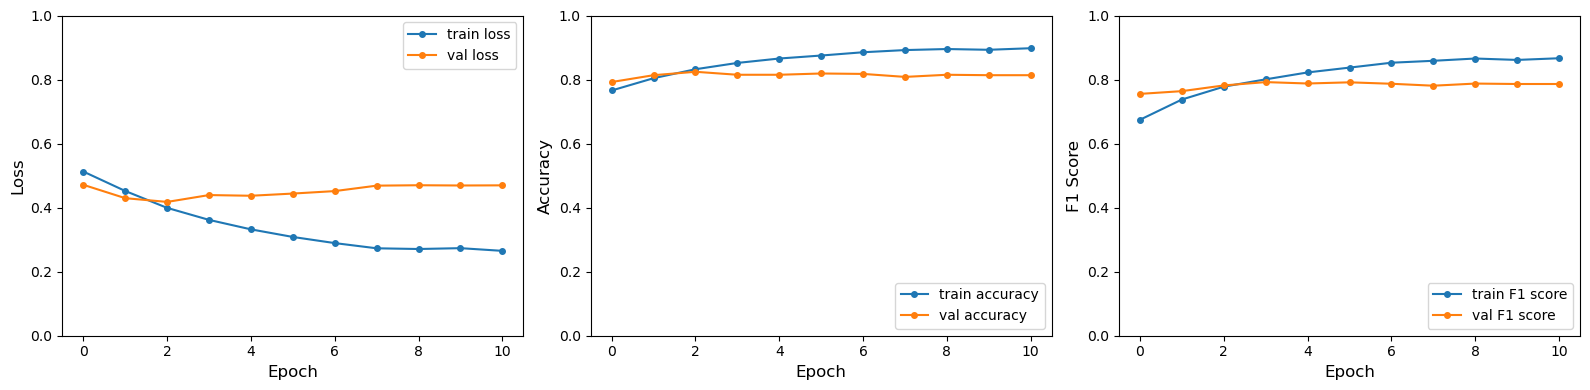

In [33]:
plot_performance(history)   # 256-128-1 With Dropout Kaggle score: 0.81213

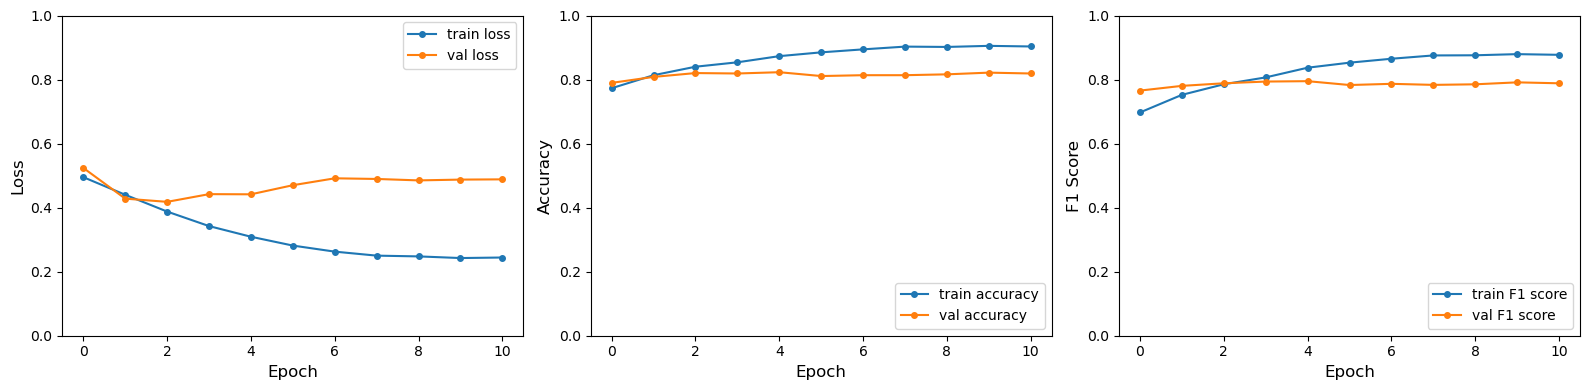

In [26]:
#plot_performance(history)   # 128-128-1 With Dropout Kaggle score: 0.80907

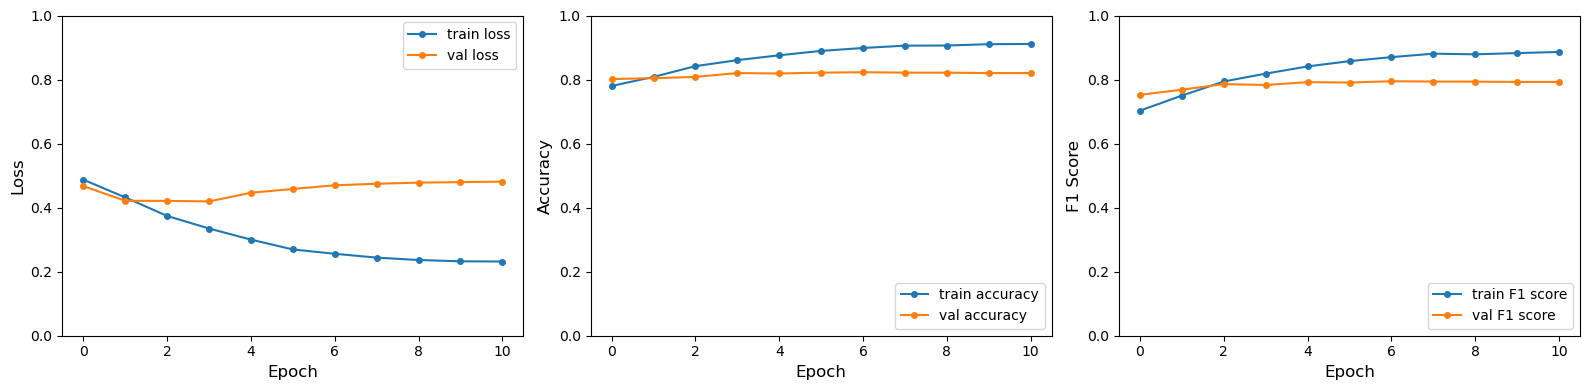

In [19]:
#plot_performance(history)   # 128-128-1 No Dropout Kaggle score: 0.80049

### Hyperparameter Tuning Summary
***
| **<center>LSTM Architecture** | **<center>Kaggle Score** |
| ------ | ------- |
| **<center>FC: 128-128-1, No Dropout, Init Learning rate: 0.003** | **<center>0.80049** |
| **<center>FC: 128-128-1, Dropout: 0.5, Init Learning rate: 0.003** | **<center>0.80907** |
| **<center>FC: 256-128-1, Dropout: 0.5, Init Learning rate: 0.003** | **<center>0.81213** |
***
Regularization through the addition of Dropout (0.5) contributed to the improved performance of the LSTM model on unseen data. Furthermore, increasing the number of units/nodes in the first fully connected layer from 128 to 256 also enhanced the model's performance.

### Kaggle Submission - LSTM

In [34]:
model_lstm.load_weights('checkpoint_keras.h5')

In [35]:
X_test_seq = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_len)

predictions = model_lstm.predict(X_test_pad)

102/102 [==============================] - 4s 37ms/step


In [36]:
submission = pd.read_csv('sample_submission.csv')
predictions = np.round(predictions)
submission['target'] = predictions.flatten().astype('int')
submission.to_csv('submission.csv', index=False)

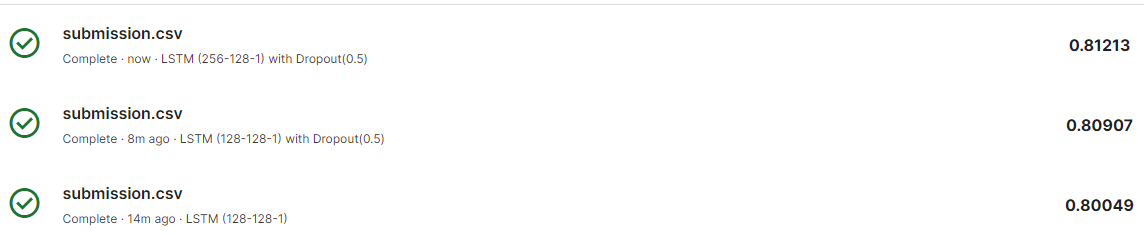

### 4.5. Bi-Directional LSTM with Attention

In [38]:
from keras.layers import Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [39]:
tf.keras.backend.clear_session()

# Embedding Layer
sequence_input = Input(shape=(max_len,))
embedded_sequences = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(sequence_input)

# RNN Layer
lstm = Bidirectional(LSTM(8, return_sequences = True, dropout=0.5, recurrent_dropout=0.5))(embedded_sequences)

# Get LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(8, return_sequences=True, return_state=True))(lstm)

# Attention Layer
att_out = attention()(lstm)
outputs = Dense(1, activation='sigmoid')(att_out)
model_attn_bilstm = Model(sequence_input, outputs)

model_attn_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

In [40]:
model_attn_bilstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           4801800   
                                                                 
 bidirectional (Bidirectiona  (None, 24, 16)           19776     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  [(None, 24, 16),         1600      
 nal)                         (None, 8),                         
                              (None, 8),                         
                              (None, 8),                         
                              (None, 8)]                         
                                                             

In [41]:
checkpoint = ModelCheckpoint('attn_model.h5', monitor='val_accuracy', save_best_only=True)

history = model_attn_bilstm.fit(X_train_pad, y_train,
                                validation_data=(X_val_pad, y_val), 
                                batch_size=32,
                                callbacks=[checkpoint],
                                epochs=15,
                                verbose=1)

Epoch 1/15
211/211 [==============================] - 18s 61ms/step - loss: 0.5398 - accuracy: 0.7435 - val_loss: 0.4530 - val_accuracy: 0.7963
Epoch 2/15
211/211 [==============================] - 12s 57ms/step - loss: 0.4544 - accuracy: 0.8009 - val_loss: 0.4407 - val_accuracy: 0.8029
Epoch 3/15
211/211 [==============================] - 12s 57ms/step - loss: 0.4324 - accuracy: 0.8081 - val_loss: 0.4340 - val_accuracy: 0.8043
Epoch 4/15
211/211 [==============================] - 12s 57ms/step - loss: 0.4219 - accuracy: 0.8144 - val_loss: 0.4269 - val_accuracy: 0.8123
Epoch 5/15
211/211 [==============================] - 12s 57ms/step - loss: 0.4111 - accuracy: 0.8209 - val_loss: 0.4267 - val_accuracy: 0.8123
Epoch 6/15
211/211 [==============================] - 12s 57ms/step - loss: 0.4095 - accuracy: 0.8199 - val_loss: 0.4243 - val_accuracy: 0.8149
Epoch 7/15
211/211 [==============================] - 12s 57ms/step - loss: 0.3961 - accuracy: 0.8309 - val_loss: 0.4143 - val_accuracy:

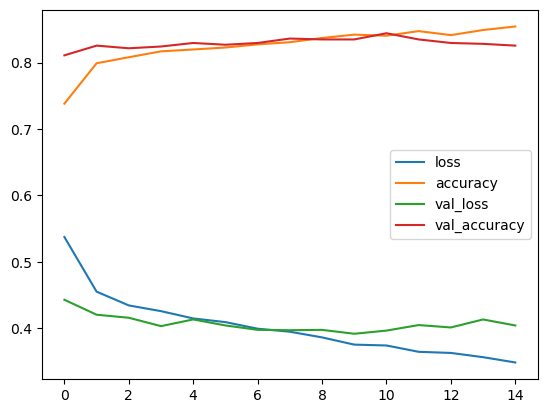

In [186]:
pd.DataFrame(history.history).plot();   # 8-8-1 dropout=0.5 lr=0.001, kaggle score: 0.81765

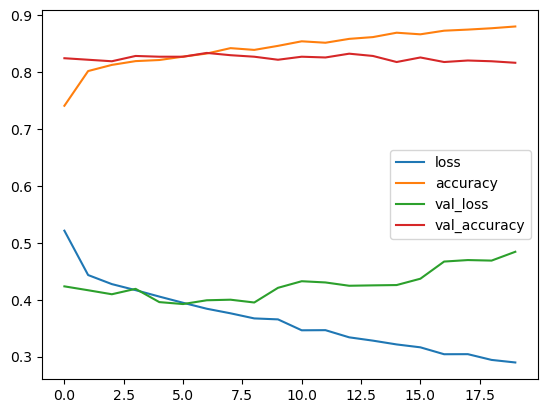

In [155]:
#pd.DataFrame(history.history).plot();   # 16-16-1 dropout=0.5 lr=0.001, kaggle score: 0.81673

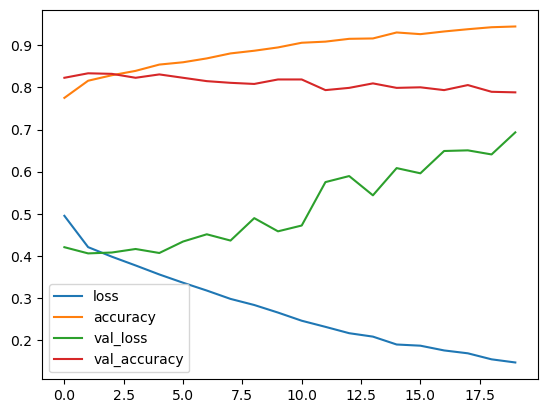

In [144]:
#pd.DataFrame(history.history).plot();   # 16-16-1 dropout=0.2 lr=0.001, kaggle score: 0.80539

### Hyperparameter Tuning Summary
***
| **<center>Bi-directional LSTM with Attention Architecture** | **<center>Kaggle Score** |
| ------ | ------- |
| **<center>FC: 16-16-1, Dropout: 0.2, Learning rate: 0.001** | **<center>0.80539** |
| **<center>FC: 16-16-1, Dropout: 0.5, Learning rate: 0.001** | **<center>0.81673** |
| **<center>FC: 8-8-1, Dropout: 0.5, Learning rate: 0.001** | **<center>0.81765** |
***

Increasing the dropout from 0.2 to 0.5 and reducing the number of nodes (neurons) in Fully Connected (FC) layer, help reduced overfitting. We can see this from the plot (the validation loss is not blowing up). Accordingly, the model predict test data better.

In [43]:
# Store history for bilstm model
df_history = pd.DataFrame(history.history)

# Save history
df_history.to_csv('attn_bilstm_history.csv', index=False)

### Kaggle Submission - Bi-Directional LSTM with Attention Model

In [44]:
model_attn_bilstm.load_weights('attn_model.h5')

In [45]:
X_test_seq = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_len)

predictions = model_attn_bilstm.predict(X_test_pad)

102/102 [==============================] - 3s 21ms/step


In [46]:
submission = pd.read_csv('sample_submission.csv')
predictions = np.round(predictions)
submission['target'] = predictions.flatten().astype('int')
submission.to_csv('submission.csv', index=False)

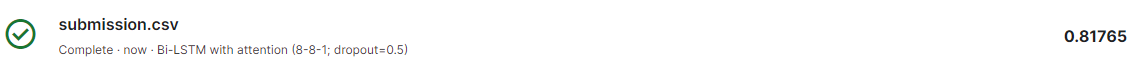

### 4.6. Universal Sequence Encoder

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

import tensorflow_hub as hub

In [12]:
# module_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
# module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
sentence_encoder_layer = hub.KerasLayer(module_url,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE_embedding")

In [57]:
tf.keras.backend.clear_session()

model_univ_sentence_encoder = tf.keras.Sequential([
    sentence_encoder_layer,
    Dense(16, activation='relu'),
    #BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    #BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name = 'universal_sentence_encoder')

In [58]:
model_univ_sentence_encoder.summary()

Model: "universal_sentence_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  {'outputs': (None, 512)}  147354880 
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 147,363,377
Trainable para

In [15]:
X, y = train['cleaned_text'].values, train['target_relabeled'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [59]:
model_univ_sentence_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [60]:
history = model_univ_sentence_encoder.fit(X_train, y_train, 
                                     validation_data=(X_val, y_val), 
                                     callbacks=get_callbacks(),
                                     epochs=20)

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6943 - f1_score: 0.4309
Epoch 1: val_f1_score improved from -inf to 0.71578, saving model to checkpoint_keras.h5
188/188 [==============================] - 62s 253ms/step - loss: 0.6015 - accuracy: 0.6943 - f1_score: 0.4309 - val_loss: 0.5339 - val_accuracy: 0.7801 - val_f1_score: 0.7158 - lr: 0.0030
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.7934 - f1_score: 0.7514
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.

Epoch 2: val_f1_score improved from 0.71578 to 0.73816, saving model to checkpoint_keras.h5
188/188 [==============================] - 39s 207ms/step - loss: 0.5195 - accuracy: 0.7934 - f1_score: 0.7514 - val_loss: 0.4973 - val_accuracy: 0.7835 - val_f1_score: 0.7382 - lr: 0.0030
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.8009 - f1_score: 0.7613
Epoch 3: ReduceLROnP

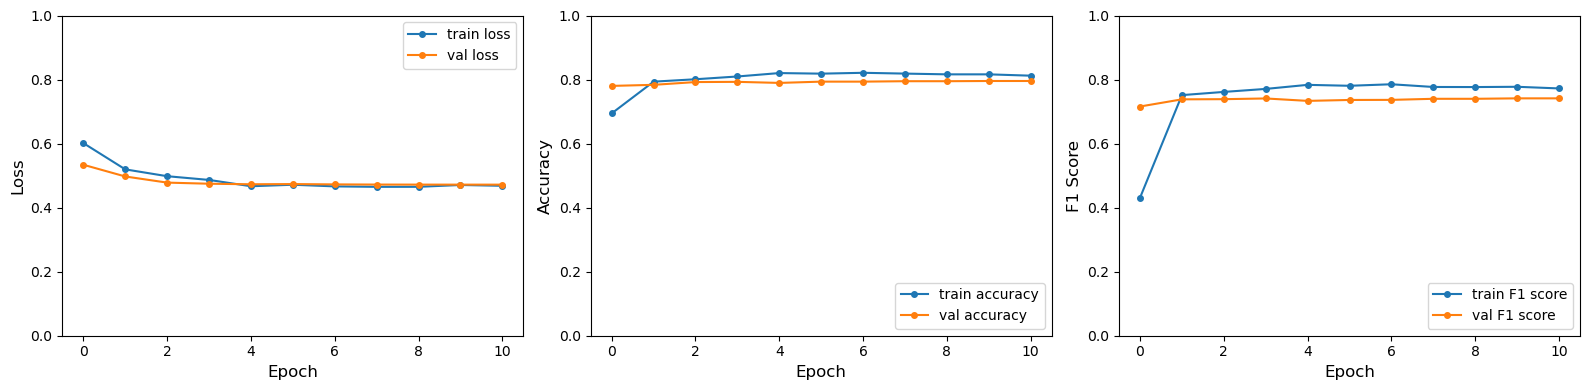

In [61]:
#plot_performance(history)   # USE FC: 16-16-1 with Dropout and BatchNormalization Kaggle score: 0.81029

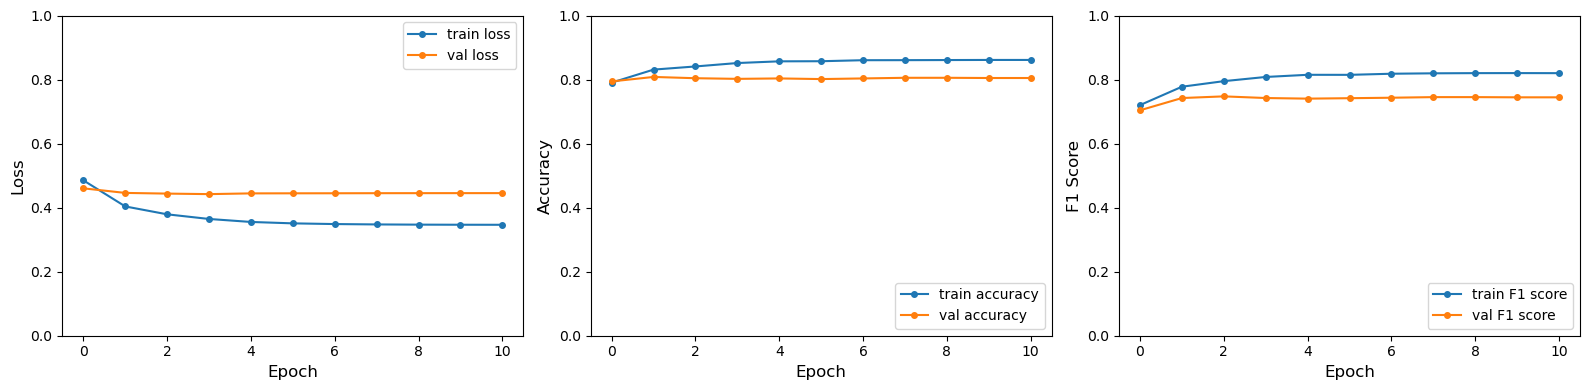

In [53]:
#plot_performance(history)   # USE FC: 16-16-1 No Dropout, No BatchNormalization Kaggle score: 0.79221

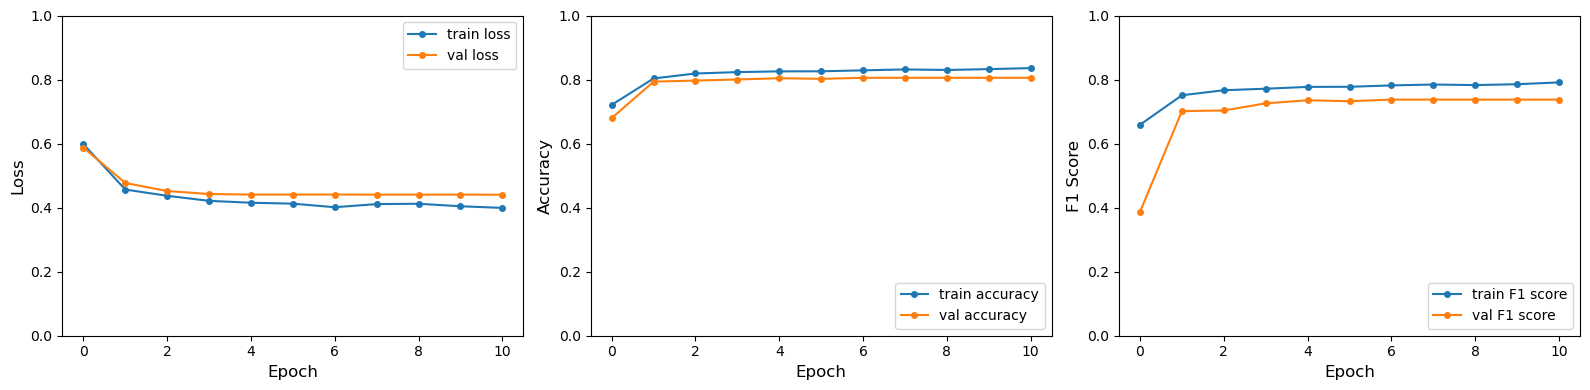

In [28]:
#plot_performance(history)   # USE FC: 32-32-1 Kaggle score: 0.80324

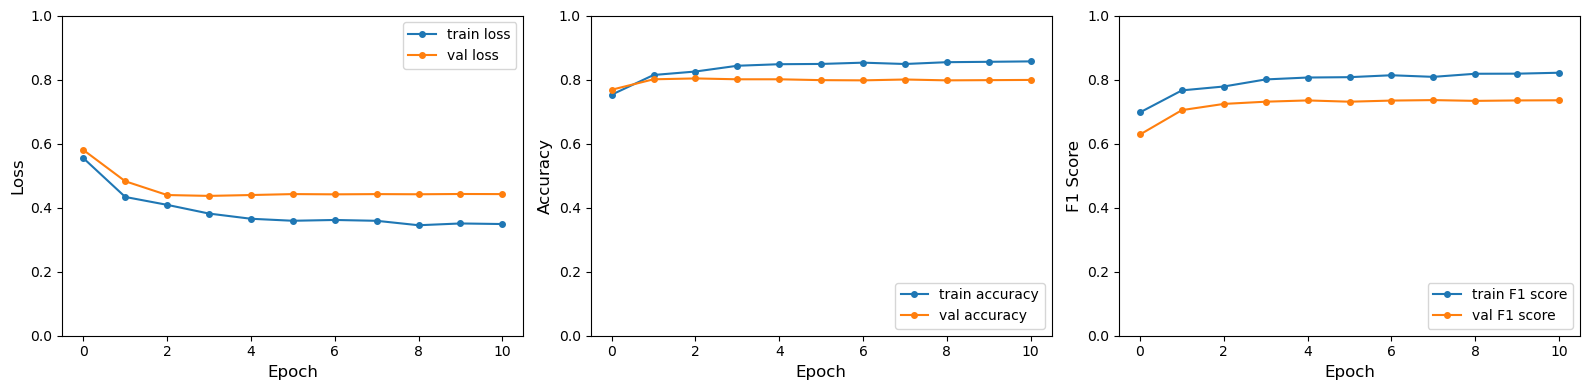

In [20]:
#plot_performance(history)   # USE FC: 128-64-1 Kaggle score: 0.80999

In [45]:
# Store history for univ_seq_encoder model
df_history = pd.DataFrame(history.history)

# Save history
df_history.to_csv('univ_sentence_encoder_history.csv', index=False)

### Hyperparameter Tuning Summary
***
| **<center>Universal Sentence Encoder Architecture** | **<center>Kaggle Score** |
| ------ | ------- |
| **<center>FC: 128-64-1, Dropout: 0.5, BatchNormalization applied, Init Learning rate: 0.003** | **<center>0.80999** |
| **<center>FC: 32-32-1, Dropout: 0.5, BatchNormalization applied, Init Learning rate: 0.003** | **<center>0.80324** |
| **<center>FC: 16-16-1, Dropout: 0.5, BatchNormalization applied, Init Learning rate: 0.003** | **<center>0.81029** |
| **<center>FC: 16-16-1, No Dropout, No BatchNormalization, Init Learning rate: 0.003** | **<center>0.79221** |
***

Regularization method such as Dropout and BatchNormalization help model generalized better to unseen data. Increasing the number of nodes in Fully Connected layer did not improve model performance. 

### Kaggle Submission Universal Sentence Encoder

In [62]:
# load best weights
model_univ_sentence_encoder.load_weights('checkpoint_keras.h5')

In [63]:
predictions = model_univ_sentence_encoder.predict(test['cleaned_text'].values)

102/102 [==============================] - 24s 156ms/step


In [64]:
submission = pd.read_csv('sample_submission.csv')
predictions = np.round(predictions)
submission['target'] = predictions.flatten().astype('int')
submission.to_csv('submission.csv', index=False)

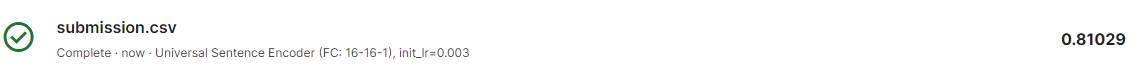

### 4.7. RoBERTa

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFRobertaForSequenceClassification

In [10]:
import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", message="`resume_download` is deprecated", category=FutureWarning)

from transformers import logging
logging.set_verbosity_warning()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_text'], train['target_relabeled'], stratify=train['target_relabeled'], test_size=0.1, random_state=42)

In [8]:
model_name = 'roberta-large'
#model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
val_tokenized = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf')

In [11]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model_roberta.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 354310144 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 1051650   
 ficationHead)                                                   
                                                                 
Total params: 355,361,794
Trainable params: 355,361,794
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.9e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_roberta.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
chkpt = './checkpoint'
callback_chkpt = tf.keras.callbacks.ModelCheckpoint(chkpt,
                                                    monitor='val_accuracy',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    mode='max')

history = model_roberta.fit(dict(train_tokenized), y_train,
                            validation_data=(dict(val_tokenized), y_val), 
                            batch_size=32,
                            callbacks=[callback_chkpt],
                            epochs=5,
                            verbose=1)

Epoch 1/5
211/211 [==============================] - 74s 204ms/step - loss: 0.5850 - accuracy: 0.6777 - val_loss: 0.4680 - val_accuracy: 0.7936
Epoch 2/5
211/211 [==============================] - 38s 179ms/step - loss: 0.4179 - accuracy: 0.8267 - val_loss: 0.4642 - val_accuracy: 0.8083
Epoch 3/5
211/211 [==============================] - 38s 178ms/step - loss: 0.3857 - accuracy: 0.8398 - val_loss: 0.4658 - val_accuracy: 0.8123
Epoch 4/5
211/211 [==============================] - 30s 138ms/step - loss: 0.3573 - accuracy: 0.8543 - val_loss: 0.4603 - val_accuracy: 0.8096
Epoch 5/5
211/211 [==============================] - 30s 142ms/step - loss: 0.3408 - accuracy: 0.8605 - val_loss: 0.4645 - val_accuracy: 0.8109


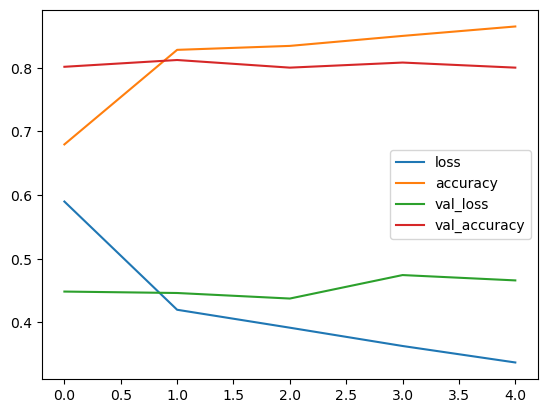

In [10]:
pd.DataFrame(history.history).plot();     # 'roberta-large' learning rate: 1.9e-6 kaggle score: 0.82439

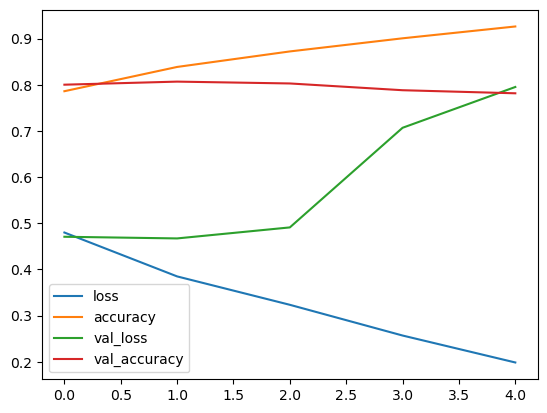

In [42]:
#pd.DataFrame(history.history).plot();     # 'roberta-base' kaggle score: 0.80723

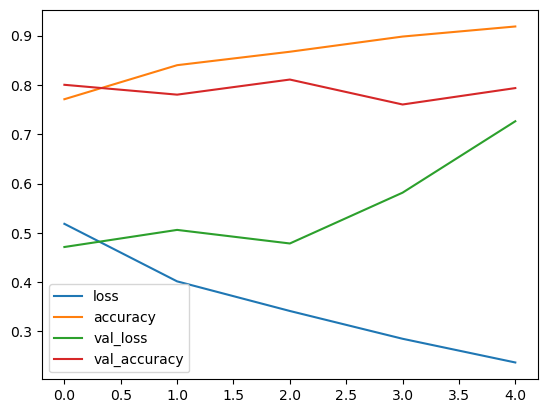

In [21]:
#pd.DataFrame(history.history).plot();     # 'roberta-large' learning rate: 3e-5 kaggle score: 0.82163

### Hyperparameter Tuning Summary
***
| **<center>RoBERTa Architecture** | **<center>Kaggle Score** |
| ------ | ------- |
| **<center>RoBERTa-base model, learning rate=5e-6** | **<center>0.80723** |
| **<center>RoBERTa-large model, learning rate=5e-6** | **<center>0.82163** |
| **<center>RoBERTa-large model, learning rate=1.9e-6** | **<center>0.82439** |
***
RoBERTa-large model has better performance compared to RoBERTa-base model. Additionally, reducing the learning rate from 5e-6 to 1.9e-6 further improved its performance.

### Kaggle Submission RoBERTa

In [23]:
# load best weights
model_roberta.load_weights(chkpt)

In [24]:
test_tokenized = tokenizer(test['cleaned_text'].tolist(), padding=True, truncation=True, return_tensors='tf')

In [25]:
predictions = model_roberta.predict(dict(test_tokenized))

102/102 [==============================] - 12s 70ms/step


In [26]:
y_pred = predictions[0].argmax(axis=1)

In [27]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)

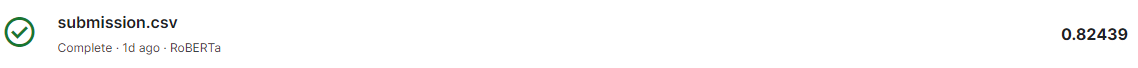

### RoBERTa with keyword, location added to tweets

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop_duplicates(subset=['keyword', 'location', 'text', 'target'])

In [16]:
train['doc'] = train['text'] + ' keyword_' + train['keyword'].astype(str) + ' location_' + train['location'].astype(str).apply(lambda x: ' location_'.join(x.split()))
test['doc'] = test['text'] + ' keyword_' + test['keyword'].astype(str) + ' location_' + test['location'].astype(str).apply(lambda x: ' location_'.join(x.split()))

In [17]:
# reduce test_size from 0.1 to 0.05
train, val, y_train, y_val = train_test_split(train, train['target'], test_size=0.05, stratify=train['target'], random_state=500)

In [18]:
model_name = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_tokenized = tokenizer(train['doc'].tolist(), padding=True, truncation=True, return_tensors='tf')
val_tokenized = tokenizer(val['doc'].tolist(), padding=True, truncation=True, return_tensors='tf')

In [19]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model_roberta.summary()

Model: "tf_roberta_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 354310144 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 1051650   
 ficationHead)                                                   
                                                                 
Total params: 355,361,794
Trainable params: 355,361,794
Non-trainable params: 0
_________________________________________________________________


In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.9e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_roberta.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [40]:
chkpt = './checkpoint'
callback_chkpt = tf.keras.callbacks.ModelCheckpoint(chkpt,
                                                    monitor='val_accuracy',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    mode='max')

history = model_roberta.fit(dict(train_tokenized), y_train,
                            validation_data=(dict(val_tokenized), y_val), 
                            batch_size=32,
                            callbacks=[callback_chkpt],
                            epochs=5,
                            verbose=1)

Epoch 1/5
225/225 [==============================] - 79s 259ms/step - loss: 0.5259 - accuracy: 0.7377 - val_loss: 0.3553 - val_accuracy: 0.8443
Epoch 2/5
225/225 [==============================] - 50s 222ms/step - loss: 0.3813 - accuracy: 0.8460 - val_loss: 0.4075 - val_accuracy: 0.8338
Epoch 3/5
225/225 [==============================] - 56s 249ms/step - loss: 0.3517 - accuracy: 0.8577 - val_loss: 0.3386 - val_accuracy: 0.8654
Epoch 4/5
225/225 [==============================] - 56s 250ms/step - loss: 0.3256 - accuracy: 0.8718 - val_loss: 0.3259 - val_accuracy: 0.8707
Epoch 5/5
225/225 [==============================] - 50s 223ms/step - loss: 0.3085 - accuracy: 0.8808 - val_loss: 0.3530 - val_accuracy: 0.8443


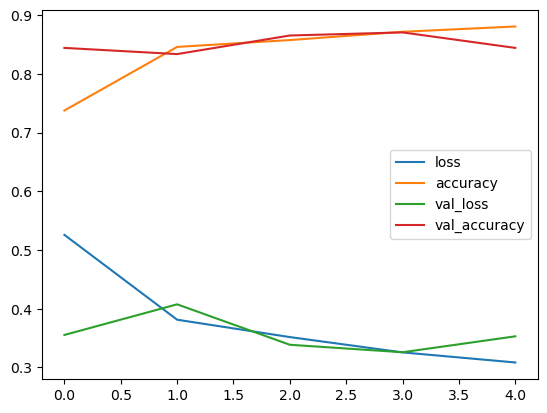

In [41]:
pd.DataFrame(history.history).plot();

### Kaggle Submission RoBERTa with keyword, location added to tweets

In [42]:
# load best weights
model_roberta.load_weights(chkpt)

In [44]:
test_tokenized = tokenizer(test['doc'].tolist(), padding=True, truncation=True, return_tensors='tf')

In [45]:
predictions = model_roberta.predict(dict(test_tokenized))

102/102 [==============================] - 10s 72ms/step


In [46]:
y_pred = predictions[0].argmax(axis=1)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)

Based on its performance on unseen test data on Kaggle, this is the best model for this Project. Below is Kaggle Leaderboard screenshot:

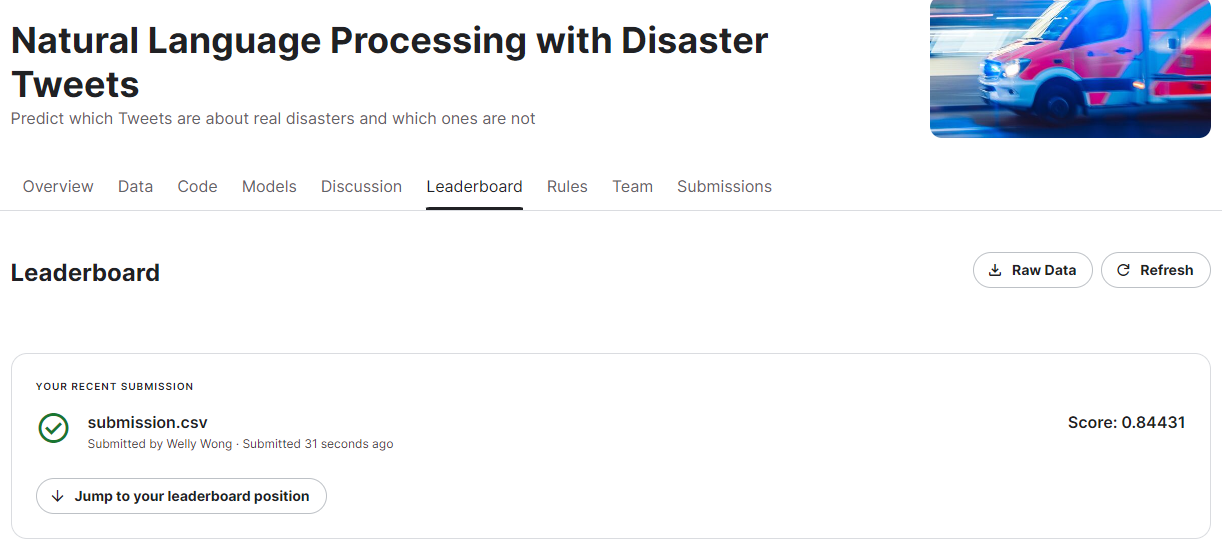

### Confusion Matrix
Lastly, we will plot the confusion matrix based on our best model's prediction on the validation data and y_val. The F1 score that we obatin from our validation dataset is closed to the one we achieved on from Kaggle.

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [55]:
predictions = model_roberta.predict(dict(val_tokenized))

10/10 [==============================] - 1s 63ms/step


In [56]:
tn, fp, fn, tp = confusion_matrix(y_val, predictions[0].argmax(axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

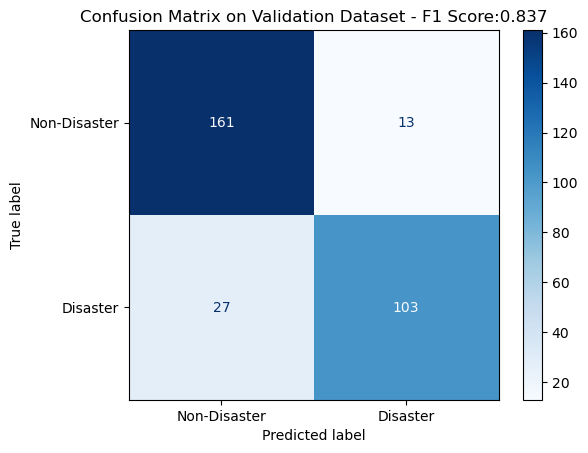

In [58]:
cm = ConfusionMatrixDisplay.from_predictions(y_val, predictions[0].argmax(axis=1),
                                        display_labels=['Non-Disaster', 'Disaster'], cmap=plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix on Validation Dataset - F1 Score:' + str(f1_score.round(3)));

### 4.8. Feature-based Model
Here, we used sklearn's RandomForestClassifier on our meta-features (polarity, subjectivity, number of characters, number of words and number of sentences). This model only achieved 68.4% accuracy on the validation data. Clearly, neural network model is the better learner.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [12]:
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(train['target_relabeled']),
                                     y= train['target_relabeled'])

class_weights = {k:class_weights[k] for k in np.unique(train['target_relabeled'])}

In [13]:
X = train[['num_char', 'num_word', 'num_sentence', 'polarity', 'subjectivity']]
y = train['target_relabeled']

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [12]:
clf = RandomForestClassifier(n_estimators=500, 
                             max_depth=15, 
                             min_samples_split=20,
                             min_samples_leaf=2,
                             #class_weight=class_weights,  # using class_weights lead to lower val acc: 0.66
                             n_jobs=-1, 
                             random_state=42)

clf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [13]:
clf_pred = clf.predict_proba(X_val.values)

print('Validation Accuracy:', accuracy_score(y_val.values, clf_pred.argmax(axis=-1)))

Validation Accuracy: 0.6844207723035952


## 5. Conclusion and take away
* The cleaning process took a significant amount of time in NLP workflows.
* Hyperparameters tuning through experimentation and validation to find the optimal values is time-consuming yet essential aspect of developing a robust model.
* Pre-trained word embeddings, such as GloVe, which we used in this project, are trained on large corpora of text and are typically able to capture the semantic and syntactic meaning of a word. Therefore, they perform better than implementing word embeddings from scratch.
* Transfer learning from pre-trained Transformer models such as RoBERTa, excels in performance compared to the other models (LSTM with GloVe, Bi-directional LSTM with attention with GloVe, Universal Sentence Encoder) that we implemented in this project.

What did and did not help improve the performance of the models:
* Reducing the number of units/nodes in Bi-directional LSTM with attention model and increasing Dropout from 0.2 to 0.5, improved the model's performance. Our dataset is relatively small. By increasing regularization strength and reducing model complexity, we are addressing the overfitting concerns associated with the small dataset.
* Incorporating 'keyword' and 'location' information led to an improvement in the performance of the RoBERTa model.
* Using class weights to address slight class imbalance did not help. The validation loss is consistently higher than the training loss when using class weights.

What improvements could you try in the future?
* Ensemble: combine multiple trained models to leverage the diversity of their predictions, this might improve classification performance.
* Various attention mechanisms can be explored such as self-attention mechanisms like Transformer's multi-head attention.


## References
* Andrew Ng. 5th course - Sequence Model - RNN. [Youtube Link](https://www.youtube.com/watch?v=S7oA5C43Rbc)
* Analyticsvidhya. A Comprehensive Guide to Attention Mechanism. [Blog Link](https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/)
* Analyticsvidhya. Guide to Pretrained Word Embeddings for NLP Practitioners. [Blog Link](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)
* Gunes Evitan. NLP with Disaster Tweets - EDA, Cleaning and BERT. [Kaggle Link](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)
* Sandipan Dey. Disaster Tweets Classification with RNN – GRU/ BiLSTM/ BERT/ USE. [Blog Link](https://sandipanweb.wordpress.com/2023/03/31/nlp-disaster-tweets-kaggle-mini-project/)